In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing

from classification_problem import Classification

In [374]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

def to_one_hot(category_array):
    ca = category_array # 1D array with values of the categories
    nr_categories = np.max(ca)+1
    nr_points = len(ca)
    one_hot = np.zeros((nr_points,nr_categories),dtype=int)
    one_hot[range(nr_points),ca] = 1
    return one_hot

def from_one_hot(one_hot_array):
    category_arr = np.nonzero(one_hot_array)[1]
    return category_arr

class NeuralNetwork:

    def __init__(
            self,
            X_data,
            Y_data,
            problem,    # input problem class, containing activiation functions and cost functions
            n_hidden_neurons_list =[2],    # list with numbers of neurons in each layer
            n_categories=10,    # nr output layer
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0,
            debug=False):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_layers = len(n_hidden_neurons_list)
        self.n_hidden_neurons_list = n_hidden_neurons_list
        self.n_categories = n_categories

        self.Problem = problem
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        self.debug = debug
        self.accuracy_each_epoch_train = np.zeros(epochs)
        self.accuracy_each_epoch_test = np.zeros(epochs)

        self.initialize_layers()

    def initialize_layers(self):
        # n_hidden = self.n_hidden_neurons_list
        # self.hidden_bias_list = [np.zeros(n)+0.01 for n in n_hidden]
        # self.hidden_weights_list = [np.random.randn(self.n_features,n_hidden[0])]    # Weight for first hidden layer(l=2)
        # # Dimension of layers l dependenent on layer l-1 and number of 
        # for i in range(1,self.n_layers):
        #     self.hidden_weights.append(np.random.randn(n_hidden[i-1],n_hidden[i]))

        # self.output_weights = np.random.randn(self.n_hidden_neurons[-1], self.n_categories)
        # self.output_bias = np.zeros(self.n_categories) + 0.01

        n_hidden = self.n_hidden_neurons_list
        # Bias of layers l = [1,L-1]:
        self.bias_list = [np.zeros(n)+0.01 for n in n_hidden]
        # appending output layer:
        self.bias_list.append(np.zeros(self.n_categories)+0.01)
        
        # Weights for l = [1,L-1]:
        self.weights_list = [np.random.randn(self.n_features,n_hidden[0])]    # From input to l=1
        # Dimension of layers l dependenent on layer l-1:
        for i in range(1,self.n_layers):
            self.weights_list.append(np.random.randn(n_hidden[i-1],n_hidden[i]))
        # appending output layer:
        self.weights_list.append(np.random.randn(n_hidden[-1], self.n_categories))
    
    def printshape(self,x,name='x'):
        if isinstance(x,list):
            x = np.array(x)
        if self.debug:
            print('shape '+name,x.shape)
            
    def sigmoid(self,z):
        """ Returns sigmoid activation function for hidden layers """
        return 1/(1+np.exp(-z))

    def sigmoid_prime(self,z):
        """ Returns derivative of sigmoid """
        return self.sigmoid(z)*(1-self.sigmoid(z))

    def softmax(self,z):
        """ Returns the softmax function """
        exp_term = np.exp(z)
        return exp_term/np.sum(exp_term, axis=1, keepdims=True)

    def feed_forward(self):
        """
        Feed forward loop used in training, looping all hidden layers and
        produces output probabilities for use in back propagation
        """
        problem = self.Problem
        # Input, Not using weights and biases for input layer
        self.a_list = [self.X_data]
        self.z_list = []

        self.printshape(self.a_list[-1],'input')
        
        # Loop through the layers, store weighted sum and activations
        i = 1
        for w,b in zip(self.weights_list,self.bias_list):
            
            self.z_list.append(np.matmul(self.a_list[-1],w)+b)         #np.matmul(self.a_list[-1],w)+b)
            self.a_list.append(self.sigmoid(self.z_list[-1]))
            
            self.printshape(w,'w'+str(i))
            self.printshape(b,'b'+str(i))
            self.printshape(self.a_list[-1],'a'+str(i))
            i+=1

        self.probabilities = self.softmax(self.z_list[-1])

    def feed_forward_out(self, X):
        problem = self.Problem
        # Input, Not using weights and biases for input layer
        a_list = [X]
        z_list = []

        for w,b in zip(self.weights_list,self.bias_list):
            z_list.append(np.matmul(a_list[-1],w)+b)
            a_list.append(self.sigmoid(z_list[-1]))

        probabilities = self.softmax(z_list[-1])
        return probabilities

    def backpropagation(self):
        """
        Performs the back propagation algorithm, with output from forward pass
        in self.probabilities. Uses the expressions from the given Problem class
        to compute the errors.
        """
        ## Find errors from each layer: ##
        ## ---------------------------- ##
        error_list = []
        # Finds the output error (delta^L) using the given cost function from Problem

        self.printshape(self.probabilities,'prob',)
        self.printshape(self.Y_data,'Y_data',)
        
        output_error = self.Problem.output_error(self.probabilities,self.Y_data)
        error_list.append(output_error)
        self.printshape(output_error,'output error')

        # Propagate error back in the hidden layers to find error from each layer
        L = self.n_layers   # last layer number
                            # (usually not so high nr of layers, so looping multiple times for easy implementation)
        for l in range(2,L): 
            prev_error = error_list[-1]
            prev_w = self.weights_list[-l+1]
            current_z = self.z_list[-l]
            error_hidden = np.matmul(prev_error,prev_w.T)*self.sigmoid_prime(current_z)  # CHECK ORDER IN MATMUL?
            error_list.append(error_hidden)

        # Error_list is optained backwards, sorting to match layer numbers
        error_list.reverse()
        if self.debug:
            print('number of errors ',len(error_list))

        ## Find gradients from each layer: ##
        ## ------------------------------- ##
        # List for storing the gradient for each layer
        grad_w_list = [np.zeros(w.shape) for w in self.weights_list]
        grad_b_list = [np.zeros(b.shape) for b in self.bias_list]

        # Looping over all layers
        for l in range(self.n_layers):
            
            self.printshape(self.a_list[l].T,'a.T'+str(l))
            self.printshape(error_list[l],'error'+str(l))
            
            # Finding gradients (storing for now)
            grad_b_list[l] += np.sum(error_list[l],axis=0)
            grad_w_list[l] += np.matmul(self.a_list[l+1].T,error_list[l])


            if self.lmbd > 0.0: # If using regularization
                grad_w_list[l] += self.lmbd * self.weights_list[l]
    
            self.printshape(self.weights_list[l],'w'+str(l))
            self.printshape(grad_w_list[l],'grad_w'+str(l))
            
            # Update weights and biases
            self.weights_list[l] -= self.eta*grad_w_list[l]
            self.bias_list[l] -= self.eta*grad_b_list[l]
        
    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()
            self.accuracy_each_epoch_test[i] = accuracy_score(from_one_hot(Y_test),self.predict(X_test_scaled))
            self.accuracy_each_epoch_train[i] = accuracy_score(from_one_hot(self.Y_data_full),self.predict(self.X_data_full))


In [375]:
#def accuracy_score(Y_test, Y_pred):
#    return np.sum(Y_test == Y_pred) / len(Y_test)
#
#def accuracy_score2(Y_test, Y_pred):
#    return np.sum(np.argwhere(Y_test==1)[:,1] == Y_pred)/len(Y_test)

In [376]:
input_data = np.arange(0, 1000).reshape(1000,1)
output_data = np.zeros(len(input_data),dtype=int)
output_data[floor(len(input_data)/2):] = 1
output_one_hot = to_one_hot(output_data)
nr_params = output_one_hot.shape[1]
nr_datapoints = input_data.shape[0]; nr_datapoints,nr_params

(1000, 2)

In [377]:
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_onehot)
Scaler = preprocessing.StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

In [379]:
hidden_neuron_list = [5,4,7]
nn = NeuralNetwork( X_train_scaled,
                    Y_train,
                    problem = Classification,
                    n_hidden_neurons_list=hidden_neuron_list,
                    n_categories=2,
                    epochs=500,
                    batch_size=10,
                    eta=1e-5,
                    lmbd=0.0,
                    debug=True)
nn.train()

shape input (10, 1)
shape w1 (1, 5)
shape b1 (5,)
shape a1 (10, 5)
shape w2 (5, 4)
shape b2 (4,)
shape a2 (10, 4)
shape w3 (4, 7)
shape b3 (7,)
shape a3 (10, 7)
shape w4 (7, 2)
shape b4 (2,)
shape a4 (10, 2)
shape prob (10, 2)
shape Y_data (10, 2)
shape output error (10, 2)
number of errors  2
shape a.T0 (1, 10)
shape error0 (10, 7)


ValueError: operands could not be broadcast together with shapes (5,) (7,) (5,) 

(250,)


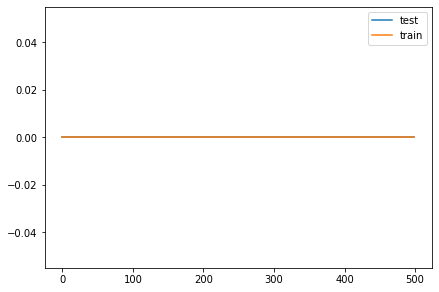

In [380]:
Y_pred = nn.predict(X_test_scaled)
print(Y_pred.shape)
#print(Y_pred)
#print(accuracy_score(from_one_hot(Y_test),Y_pred))
plt.figure()
plt.plot(np.arange(nn.epochs),nn.accuracy_each_epoch_test,label='test')
plt.plot(np.arange(nn.epochs),nn.accuracy_each_epoch_train,label='train')
plt.legend()

In [24]:
def from_one_hot(one_hot_array):
    category_arr = np.nonzero(one_hot_array)[1]
    return category_arr

Y_pred = nn.predict(X_test_scaled)
accuracy_score(from_one_hot(Y_test),Y_pred)

0.996